<a href="https://colab.research.google.com/github/SiwawawaXD/LLMclassification/blob/main/pythonCallChatgpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install -q openai

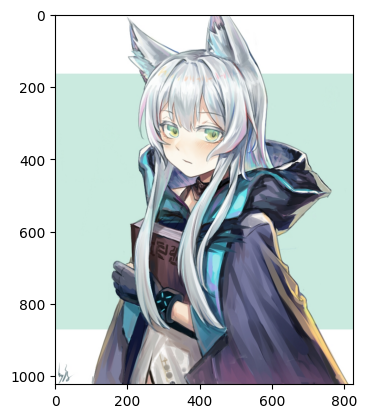

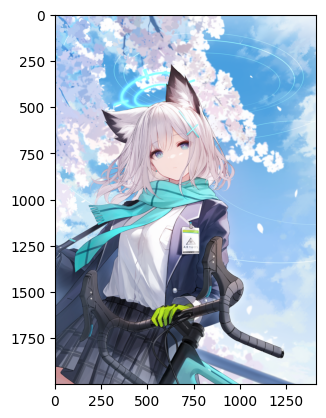

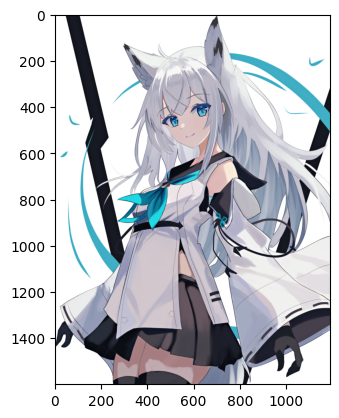

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image # Or import cv2 for OpenCV

image_path = './rosmantis/rosmantis1.jpeg' # image file path
image = Image.open(image_path) # Using PIL
plt.imshow(image)
plt.show()
image_path = './shiroko/shiroko1.png' # image file path
image = Image.open(image_path) # Using PIL
plt.imshow(image)
plt.show()
image_path = './unknown.png' # image file path
image = Image.open(image_path) # Using PIL
plt.imshow(image)
plt.show()

In [ ]:
import os
from openai import OpenAI
from google.colab import userdata
import base64

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

# Training examples
train_examples = [
    ("./rosmantis/rosmantis1.jpeg", "Rosmantis"),
    ("./rosmantis/rosmantis2.jpg", "Rosmantis"),
    ("./rosmantis/rosmantis3.jpeg", "Rosmantis"),
    ("./rosmantis/rosmantis4.jpeg", "Rosmantis"),
    ("./rosmantis/rosmantis5.png", "Rosmantis"),
    ("./shiroko/shiroko1.png", "Shiroko"),
    ("./shiroko/shiroko2.png", "Shiroko"),
    ("./shiroko/shiroko3.jpeg", "Shiroko"),
    ("./shiroko/shiroko4.jpeg", "Shiroko"),
    ("./shiroko/shiroko5.jpg", "Shiroko"),
]

# Build the messages with images inline
messages = [
    {"role": "system", "content": "You are a pro anime waifu classifier that can classify waifu from images between Shiroko and Rosmantis. Return only the class name."}
]

# Add training examples
for img_path, label in train_examples:
    img_b64 = encode_image(img_path)
    messages.append({
        "role": "user",
        "content": [
            {"type": "text", "text": f"Example: This is {label}."},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{img_b64}"}}
        ]
    })

# Add test image
test_img = "./unknown.png"
test_b64 = encode_image(test_img)
messages.append({
    "role": "user",
    "content": [
        {"type": "text", "text": "Classify this new image:"},
        {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{test_b64}"}}
    ]
})

# Use API key
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

# Call GPT-5
response = client.chat.completions.create(
    model="gpt-5-nano",   # cost น้อยสุดละ
    messages=messages,
    max_completion_tokens=5000
)

print("Classification result:", response.choices[0].message.content)


Classification result: Rosmantis
